In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import act_max_util as amu

from autoencoder import Autoencoder
from solver import *

%load_ext autoreload
%autoreload 2

### Load data

In [5]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

### Activation Maximization

In [6]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

### Load Model

In [7]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32]

In [8]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

### RFA

In [9]:
modelpath = f'/home/david/sparsify_models/good_models/01'
epoch = 49

data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

sae = load_model(modelpath, 'SAE', epoch)
dae = load_model(modelpath, 'DAE', epoch)

layer_name = 'bottle_neck'
sae_activation_dictionary = {}
dae_activation_dictionary = {}

sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))
dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

sae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=sae,
                    input=input,
                    layer_activation=sae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    sae_rf_ls.append(output.detach().numpy())

dae_rf_ls = []
for i in range(size_ls[epoch]):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=dae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

/tmp/ipykernel_21618/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

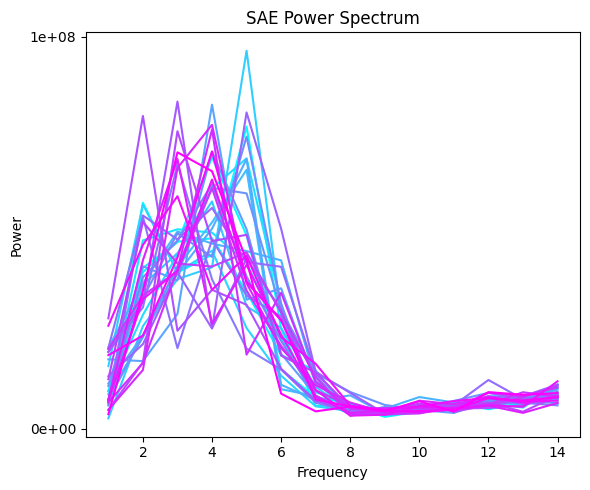

In [10]:
import matplotlib.pyplot as pl
import numpy as np
import scipy.stats as stats

colors = pl.cm.cool(np.linspace(0, 1, len(sae_rf_ls)))
pl.figure(figsize=(6, 5))

for idx, image_data in enumerate(sae_rf_ls):
    image = image_data.reshape(28, 28)
    npix = image.shape[0]

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic="mean",
                                         bins=kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    pl.plot(kvals, Abins, color=colors[idx], label=f"RF{idx+1}")

pl.xlabel('Frequency')
pl.ylabel('Power')
pl.title('SAE Power Spectrum')
yticks = [0, 1e8]
pl.yticks(yticks, [f'{ytick:.0e}' for ytick in yticks])
pl.tight_layout()
pl.show()

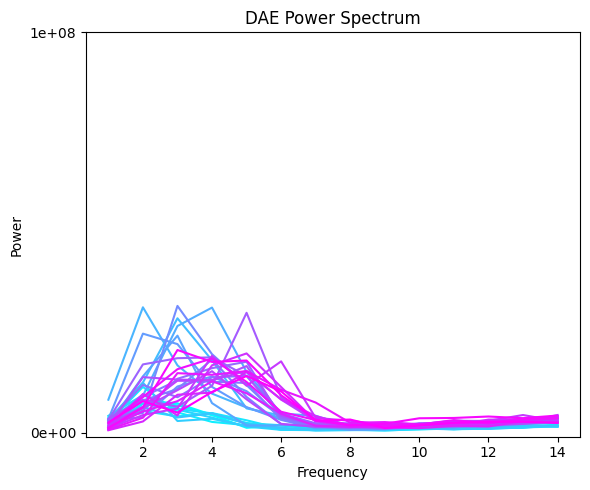

In [11]:
import matplotlib.pyplot as pl
import numpy as np
import scipy.stats as stats

colors = pl.cm.cool(np.linspace(0, 1, len(dae_rf_ls)))
pl.figure(figsize=(6, 5))

for idx, image_data in enumerate(dae_rf_ls):
    image = image_data.reshape(28, 28)
    npix = image.shape[0]

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic="mean",
                                         bins=kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    pl.plot(kvals, Abins, color=colors[idx], label=f"RF{idx+1}")

pl.xlabel('Frequency')
pl.ylabel('Power')
pl.title('DAE Power Spectrum')
yticks = [0, 1e8]
pl.yticks(yticks, [f'{ytick:.0e}' for ytick in yticks])
pl.tight_layout()
pl.show()

In [12]:
# Binning with higher resolution
def radial_profile(data, center=None):
    """
    Compute the radial profile of a 2D array data.
    """
    y, x = np.indices((data.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    r_flat = r.ravel()
    data_flat = data.ravel()

    # Get the unique radial distances and indices of the first occurrence
    unique_r, inverse_indices = np.unique(r_flat, return_inverse=True)
    
    # Sum the data values for each unique radial distance
    summed_data = np.zeros_like(unique_r)
    counts = np.zeros_like(unique_r)
    
    np.add.at(summed_data, inverse_indices, data_flat)
    np.add.at(counts, inverse_indices, 1)
    
    # Compute the average value for each unique radius
    radial_profile = summed_data / counts

    return unique_r, radial_profile

In [13]:
def z_score(image):
    """
    Normalize an image using the z-score normalization.
    Normalized image: (pixel - mean) / std
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

def radial_profile(data, center=None):
    """
    Compute the radial profile of a 2D array data.
    """
    y, x = np.indices((data.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())

    radialprofile = tbin / nr

    return radialprofile

def power_spectrum_radial_average(image):
    """
    Calculate the radial average of the power spectrum for a 2D grey-scale image.
    :param image: 2D numpy array representing the image
    :return: radial average of the power spectrum
    """
    # Take the 2D Fourier transform of the image and shift the zero frequency component to the center
    f_transform = np.fft.fftshift(np.fft.fft2(image))

    # Compute the power spectrum (magnitude squared of the Fourier coefficients)
    power_spectrum = np.abs(f_transform) ** 2

    # Compute the radial profile of the power spectrum
    radial_avg = radial_profile(power_spectrum)

    return radial_avg

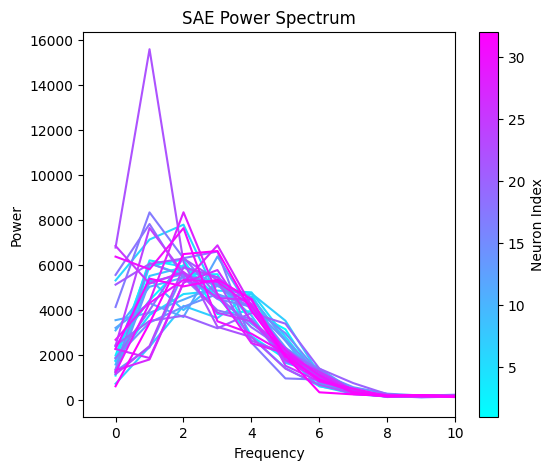

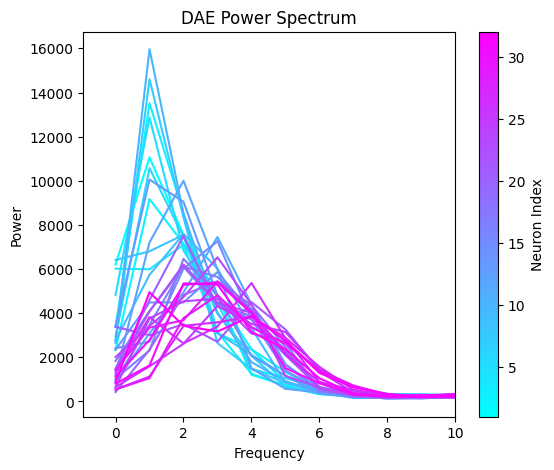

In [14]:
srf_freq_ls = []
for srf in sae_rf_ls:
    radial_avg = power_spectrum_radial_average(z_score(srf.reshape(28, 28)))
    srf_freq_ls.append(radial_avg)

drf_freq_ls = []
for drf in dae_rf_ls:
    radial_avg = power_spectrum_radial_average(z_score(drf.reshape(28, 28)))
    drf_freq_ls.append(radial_avg)

colors = plt.cm.cool(np.linspace(0, 1, 32))

plot = plt.figure(figsize=(6, 5))
ax = plot.add_subplot(111)

for i, freq in enumerate(srf_freq_ls):
    ax.plot(freq, color=colors[i], label='RF' + str(i + 1))
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title('SAE Power Spectrum')
ax.set_xlim(right=10)

norm = plt.Normalize(vmin=1, vmax=32)
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])
colorbar = plt.colorbar(sm, ax=ax, orientation='vertical')
colorbar.set_label('Neuron Index')

plt.show()

colors = plt.cm.cool(np.linspace(0, 1, 32))

plot = plt.figure(figsize=(6, 5))
ax = plot.add_subplot(111)

for i, freq in enumerate(drf_freq_ls):
    ax.plot(freq, color=colors[i], label='RF' + str(i + 1))
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title('DAE Power Spectrum')
ax.set_xlim(right=10)

norm = plt.Normalize(vmin=1, vmax=32)
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])
colorbar = plt.colorbar(sm, ax=ax, orientation='vertical')
colorbar.set_label('Neuron Index')

plt.show()

[np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(1), np.int64(3), np.int64(2), np.int64(1), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(2), np.int64(3), np.int64(2), np.int64(4), np.int64(2), np.int64(3), np.int64(3), np.int64(3), np.int64(4), np.int64(4), np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(1)]
[np.float64(35871.779153981224), np.float64(30999.870828969128), np.float64(34891.25290039274), np.float64(30672.60685051881), np.float64(35800.76620620162), np.float64(32231.19177368061), np.float64(35166.82901707933), np.float64(31739.385629815082), np.float64(30030.430661958875), np.float64(37022.29414045509), np.float64(25919.572967350647), np.float64(30317.57785296373), np.float64(33949.84745226907), np.float64(27569.397398972906), np.float64(27139.704511602707), np.float64(26120.642035116798), np.float64(25468.788153061414), np.float64(26600.718800719085), np.float64(241

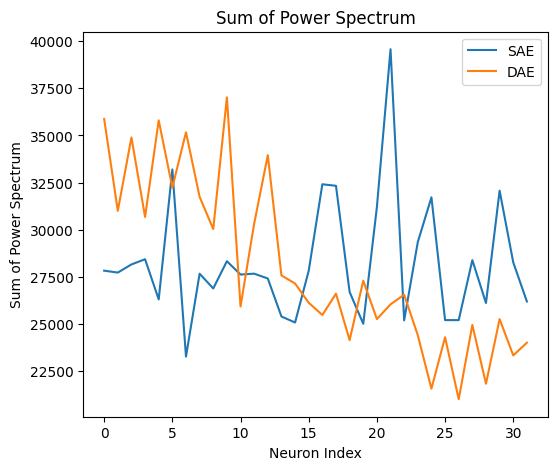

In [15]:
maximum_index = []
sums = [sum(i) for i in drf_freq_ls]

for i in drf_freq_ls:
    maximum_index.append(np.argmax(i))
    

print(maximum_index)
print(sums)

sums_s = [sum(i) for i in srf_freq_ls]
sums_d = [sum(i) for i in drf_freq_ls]

# Plot the sum of the power spectrum
plt.figure(figsize=(6, 5))
plt.plot(sums_s, label='SAE')
plt.plot(sums_d, label='DAE')
plt.xlabel('Neuron Index')
plt.ylabel('Sum of Power Spectrum')
plt.title('Sum of Power Spectrum')
plt.legend()
plt.show()


In [16]:
drf_freq_ls[20]

array([3380.62363815, 2998.54512596, 3499.0771759 , 2703.44402428,
       4499.35184533, 3262.70554472, 1381.67778777,  400.41288326,
        215.79048504,  223.61247027,  202.95093505,  227.32254281,
        211.7859394 ,  284.42725351,  262.15657262,  283.15219209,
        236.24105059,  429.82731791,  326.47103357,  222.60790062])

In [17]:
i = 4
sum(drf_freq_ls[20][i-2:i+3])

np.float64(15346.256378004375)

In [67]:
# Find threshold for a given power spectrum
# Threshold is the sum of the power spectrum / 2
# Find the frequency with the highest power
# Add the power of the neighbouring frequencies until the sum is greater than the threshold

power_spectrum = drf_freq_ls[20]

def peak_frequencies(power_spectrum):
    """
    Find the peak frequencies of a power spectrum.
    """

    threshold = sum(power_spectrum) / 2
    max_index = int(np.argmax(power_spectrum))

    current_sum = power_spectrum[max_index]

    i = max_index
    j = max_index

    while current_sum <= threshold:
        # Sum with the left neighbor
        if i - 1 >= 0:
            left_sum = current_sum + power_spectrum[i - 1]
        else:
            left_sum = current_sum  # No left neighbor
        
        # Sum with the right neighbor
        if j + 1 < len(power_spectrum):
            right_sum = current_sum + power_spectrum[j + 1]
        else:
            right_sum = current_sum  # No right neighbor

        # Check which side to add
        if left_sum > right_sum:
            current_sum = left_sum
            i -= 1
        else:
            current_sum = right_sum
            j += 1

        if current_sum > threshold:
            break

    return([*range(i, j + 1)])

for i, j in enumerate(drf_freq_ls):
    print(i, peak_frequencies(j))


0 [1, 2]
1 [1, 2]
2 [1, 2]
3 [0, 1, 2]
4 [1, 2]
5 [1, 2]
6 [1, 2]
7 [0, 1, 2]
8 [1, 2, 3]
9 [1, 2]
10 [2, 3, 4]
11 [1, 2]
12 [1, 2]
13 [1, 2, 3]
14 [2, 3, 4]
15 [2, 3, 4]
16 [2, 3, 4]
17 [1, 2, 3]
18 [2, 3, 4]
19 [1, 2, 3]
20 [2, 3, 4, 5]
21 [1, 2, 3]
22 [2, 3, 4]
23 [1, 2, 3]
24 [3, 4, 5]
25 [2, 3, 4, 5]
26 [2, 3, 4]
27 [2, 3, 4]
28 [2, 3, 4]
29 [2, 3, 4]
30 [2, 3, 4]
31 [1, 2, 3, 4]


In [19]:
def draw_circle(shape, diameter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape that says True within a circle with diameter = around center
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
    return(TF)

def filter_circle(circle_mask, full_fft_filter):
    temp = np.zeros(full_fft_filter.shape,dtype=complex)
    temp[circle_mask] = full_fft_filter[circle_mask]
    return(temp)

def add_frequency_noise(image, noise_level=1, inner_diameter=3, outer_diameter=7):
    circle_mask         = draw_circle(shape=image.shape,diameter=inner_diameter)
    outer_circle_mask   = draw_circle(shape=image.shape, diameter=outer_diameter)
    ring_mask           = outer_circle_mask & ~circle_mask

    # FFT of the image
    fft_img = np.fft.fftshift(np.fft.fft2(image))

    # Noise in given frequency range
    noise = np.random.randn(*image.shape)
    noise = np.abs(noise_level * noise * ring_mask)

    # Leave rest of frequencies as is
    not_ring_mask = ~ring_mask
    fft_img_outside = filter_circle(not_ring_mask, fft_img)

    # Combine noise and original FFT
    fft_with_noise = fft_img_outside + noise

    img_reco = np.fft.ifft2(fft_with_noise)

    return np.abs(img_reco)

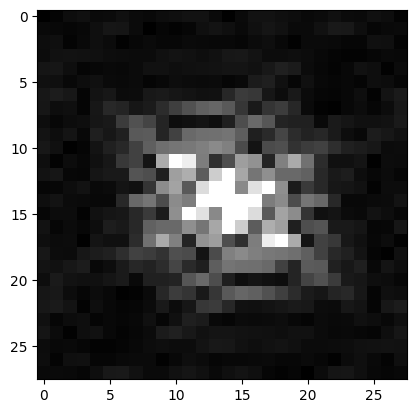

In [38]:
inner_diameter = 1
outer_diameter = 3

sample_image = train_images[3][0]

circle_mask         = draw_circle(shape=sample_image.shape,diameter=inner_diameter)
outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=outer_diameter)
ring_mask           = outer_circle_mask & ~circle_mask

fft_img = np.fft.fftshift(np.fft.fft2(sample_image))

fft_img_filtered_RING = []

full_fft_filter  = fft_img
# Ring (medium-frequency)
temp = filter_circle(ring_mask, full_fft_filter)
fft_img_filtered_RING.append(temp)
fft_img_filtered_RING = np.array(fft_img_filtered_RING)
fft_img_filtered_RING = np.transpose(fft_img_filtered_RING,(1,2,0))

# Multiply the medium-frequency components by (1 + noise_level * random_noise)
noise = np.random.randn(*fft_img_filtered_RING.shape)
fft_img_filtered_RING += 2 * noise

# plt.imshow(np.abs(full_fft_filter), cmap='gray', vmin=0, vmax=50)
plt.imshow(np.abs(full_fft_filter), cmap='gray', vmin=0, vmax=30)



np.abs(fft_img_filtered_RING)
img_reco_filtered_RING = np.fft.ifft2(fft_img_filtered_RING[:, :, 0])

In [39]:
circle_mask         = draw_circle(shape=image.shape,diameter=inner_diameter)
outer_circle_mask   = draw_circle(shape=image.shape, diameter=outer_diameter)
ring_mask           = outer_circle_mask & ~circle_mask

# FFT of the image
fft_img = np.fft.fftshift(np.fft.fft2(sample_image))

# Noise in given frequency range
noise = np.random.randn(*image.shape)
noise = np.abs(2 * noise * ring_mask)

# Leave rest of frequencies as is
not_ring_mask = ~ring_mask
fft_img_outside = filter_circle(not_ring_mask, fft_img)

# Combine noise and original FFT
fft_with_noise = fft_img_outside + noise

img_reco = np.fft.ifft2(fft_with_noise)

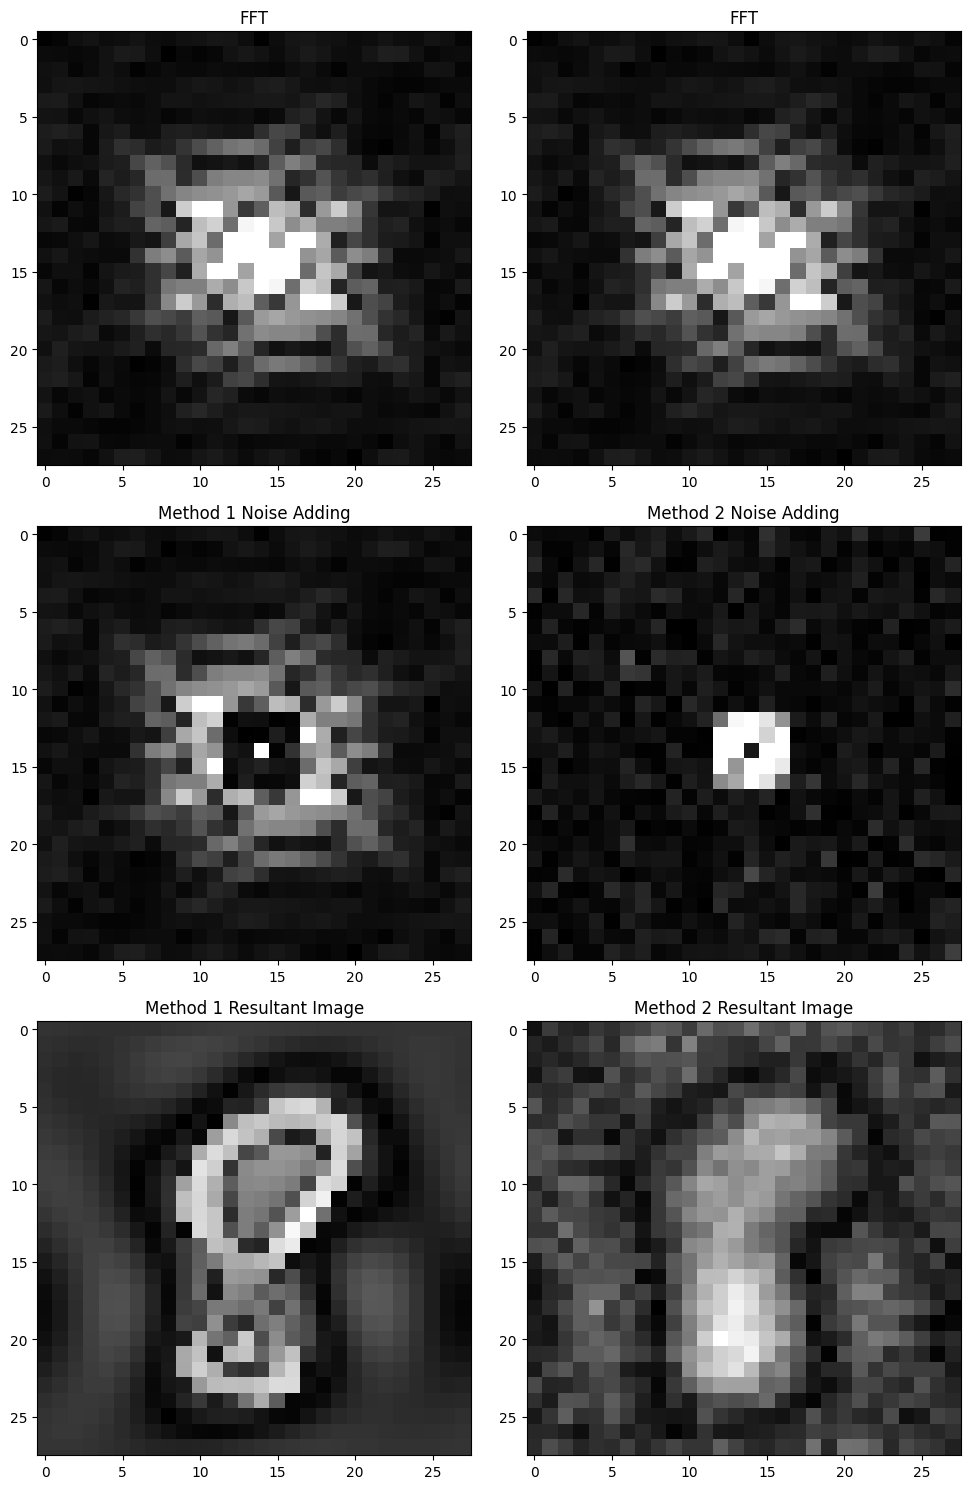

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Titles for each subplot
titles = [
    "FFT", "FFT",
    "Method 1 Noise Adding", "Method 2 Noise Adding",
    "Method 1 Resultant Image", "Method 2 Resultant Image"
]

# Assign titles to each subplot
for ax, title in zip(axes.flat, titles):
    ax.set_title(title)

# Example data generation (replace with your actual data)
x = np.linspace(0, 2 * np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
noise = np.random.normal(0, 0.1, x.size)
result1 = y1 + noise
result2 = y2 + noise

# Plot your data
# FFT plots
axes[0, 0].imshow(np.abs(fft_img), cmap='gray', vmin=0, vmax=25)  # Replace with your FFT data
axes[0, 1].imshow(np.abs(fft_img), cmap='gray', vmin=0, vmax=25)  # Replace with your FFT data

# Method 1 Noise Adding
axes[1, 0].imshow(np.abs(fft_with_noise), cmap='gray', vmin=0, vmax=25)  # Replace with your Method 1 data

# Method 2 Noise Adding
axes[1, 1].imshow(np.abs(fft_img_filtered_RING), cmap='gray', vmin=0, vmax=25)  # Replace with your Method 1 data

# Resultant Image
axes[2, 0].imshow(np.abs(img_reco), cmap='gray')  # Replace with your resultant image data

# Resultant Image of Method 2
axes[2, 1].imshow(np.abs(img_reco_filtered_RING), cmap='gray')  # Replace with your resultant image of method 2 data

# Add some space between the subplots for better visualization
fig.tight_layout()

# Display the plot
plt.show()


In [22]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

# Convert MNIST data to numpy arrays
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data).to('cuda')
    train_images.append(data.cpu().numpy())
    train_labels.append(target.cpu().numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    test_images.append(data.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

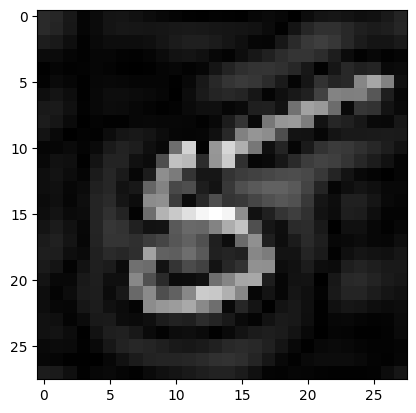

In [39]:
plt.imshow(add_frequency_noise(train_images[2][0], noise_level=1, inner_diameter=2, outer_diameter=5), cmap='gray')

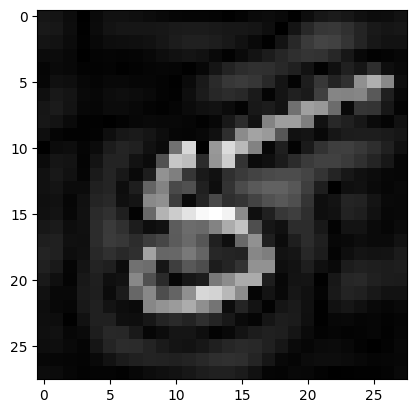

In [40]:
sample_image = train_images[2, 0]

circle_mask         = draw_circle(shape=image.shape,diameter=2)
outer_circle_mask   = draw_circle(shape=image.shape, diameter=5)
ring_mask           = outer_circle_mask & ~circle_mask

fft_img = np.fft.fftshift(np.fft.fft2(sample_image))

noise = np.random.randn(*sample_image.shape)
noise = 2 * noise * ring_mask



not_ring_mask = ~ring_mask
temp = filter_circle(not_ring_mask, fft_img)

fft_with_noise = temp + noise

# reconstruct image
img_reco = np.fft.ifft2(fft_with_noise)

plt.imshow(np.abs(img_reco), cmap='gray')

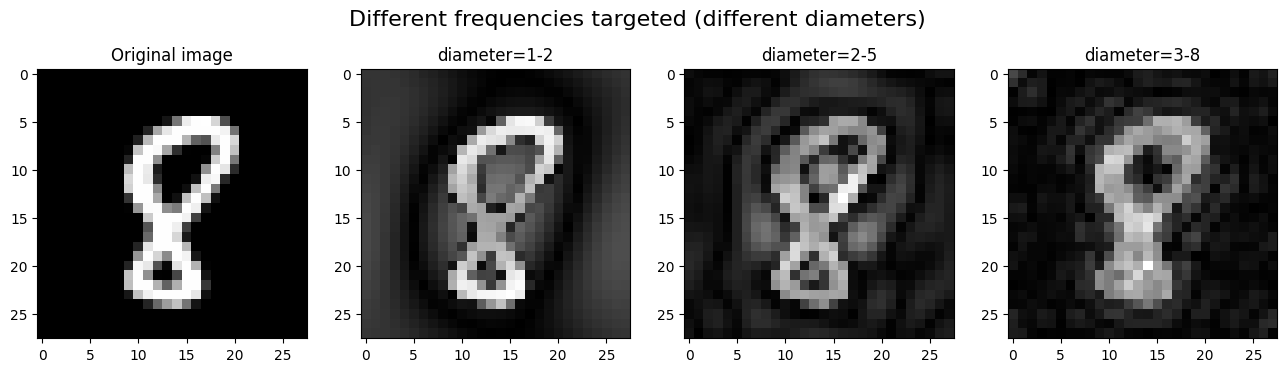

In [80]:
sample_image = train_images[3, 0]

fig = plt.figure(figsize=(16, 4))
fig.suptitle("Different frequencies targeted (different diameters)", fontsize=16)

ax  = fig.add_subplot(1,4,1)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(1,4,2)
ax.imshow(add_frequency_noise(sample_image, noise_level=2, inner_diameter=1, outer_diameter=2), cmap='gray')
ax.set_title("diameter=1-2")

ax  = fig.add_subplot(1,4,3)
ax.imshow(add_frequency_noise(sample_image, noise_level=2, inner_diameter=2, outer_diameter=5), cmap='gray')
ax.set_title("diameter=2-5")

ax  = fig.add_subplot(1,4,4)
ax.imshow(add_frequency_noise(sample_image, noise_level=2, inner_diameter=5, outer_diameter=8), cmap='gray')
ax.set_title("diameter=3-8")

plt.show()

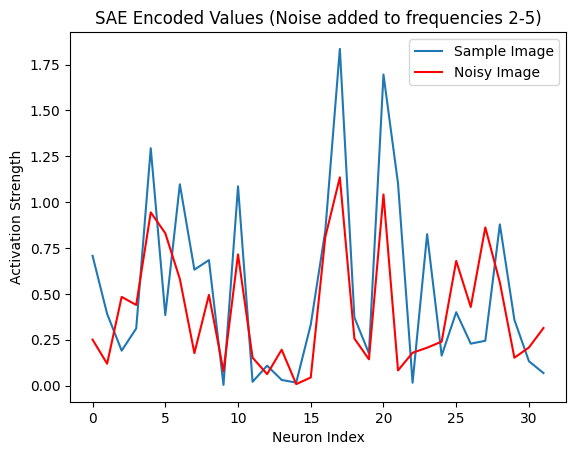

In [42]:
sample_image = train_images[3, 0]
noisy_image = add_frequency_noise(sample_image, noise_level=10, inner_diameter=2, outer_diameter=5)

with torch.no_grad():
    sample_input = torch.tensor(sample_image, dtype=torch.float32).to('cpu').reshape(-1)
    noisy_input = torch.tensor(noisy_image, dtype=torch.float32).to('cpu').reshape(-1)
    encoded, decoded = sae(sample_input)
    sae_sample_encoded = torch.abs(encoded)
    encoded, decoded = sae(noisy_input)
    sae_noisy_encoded = torch.abs(encoded)
    
plt.figure()
plt.plot(range(len(sae_sample_encoded)), sae_sample_encoded.cpu().numpy(), label='Sample Image')
plt.plot(range(len(sae_noisy_encoded)), sae_noisy_encoded.cpu().numpy(), color='red', label='Noisy Image')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Strength')
plt.title('SAE Encoded Values (Noise added to frequencies 2-5)')
plt.legend()
plt.show()

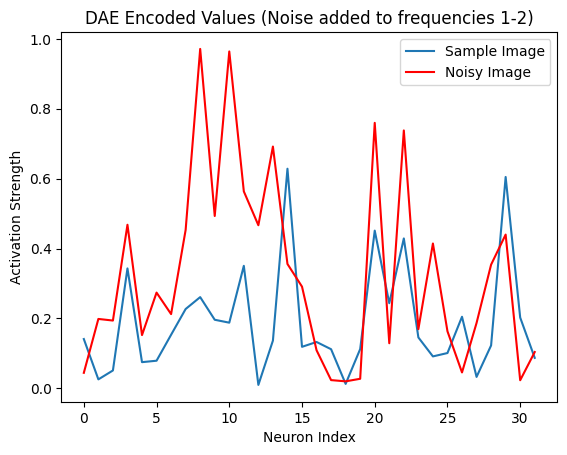

In [26]:
sample_image = train_images[2, 0]
noisy_image = add_frequency_noise(sample_image, noise_level=100, inner_diameter=1, outer_diameter=2)

with torch.no_grad():
    sample_input = torch.tensor(sample_image, dtype=torch.float32).to('cpu').reshape(-1)
    noisy_input = torch.tensor(noisy_image, dtype=torch.float32).to('cpu').reshape(-1)
    encoded, decoded = dae(sample_input)
    dae_sample_encoded = torch.abs(encoded)
    encoded, decoded = dae(noisy_input)
    dae_noisy_encoded = torch.abs(encoded)
    
plt.figure()
plt.plot(range(len(dae_sample_encoded)), dae_sample_encoded.cpu().numpy(), label='Sample Image')
plt.plot(range(len(dae_noisy_encoded)), dae_noisy_encoded.cpu().numpy(), color='red', label='Noisy Image')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Strength')
plt.title('DAE Encoded Values (Noise added to frequencies 1-2)')
plt.legend()
plt.show()

In [46]:
test_images[2][0].shape

(28, 28)

In [107]:
num_neurons = 32
sae_neuron_differences = torch.zeros(num_neurons)

for i in tqdm(range(len(test_images)), desc="Processing images"):
    sample_image = test_images[i][0]
    noisy_image = add_frequency_noise(sample_image, noise_level=2, inner_diameter=1, outer_diameter=2)

    with torch.no_grad():
        sample_input = torch.tensor(sample_image, dtype=torch.float32).to('cpu').reshape(-1)
        noisy_input = torch.tensor(noisy_image, dtype=torch.float32).to('cpu').reshape(-1)

        encoded, _ = sae(sample_input)
        sae_sample_encoded = torch.abs(encoded)
        encoded, _ = sae(noisy_input)
        sae_noisy_encoded = torch.abs(encoded)
        
        difference = torch.abs(sae_sample_encoded - sae_noisy_encoded)
        sae_neuron_differences += difference

Processing images: 100%|██████████| 10000/10000 [00:20<00:00, 484.69it/s]


In [102]:
num_neurons = 32
dae_neuron_differences = torch.zeros(num_neurons)

for i in tqdm(range(len(test_images)), desc="Processing images"):
    sample_image = test_images[i][0]
    noisy_image = add_frequency_noise(sample_image, noise_level=2, inner_diameter=1, outer_diameter=2)

    with torch.no_grad():
        sample_input = torch.tensor(sample_image, dtype=torch.float32).to('cpu').reshape(-1)
        noisy_input = torch.tensor(noisy_image, dtype=torch.float32).to('cpu').reshape(-1)

        encoded, _ = dae(sample_input)
        dae_sample_encoded = torch.abs(encoded)
        encoded, _ = dae(noisy_input)
        dae_noisy_encoded = torch.abs(encoded)
        
        difference = torch.abs(dae_sample_encoded - dae_noisy_encoded)
        dae_neuron_differences += difference

Processing images: 100%|██████████| 10000/10000 [00:21<00:00, 471.25it/s]


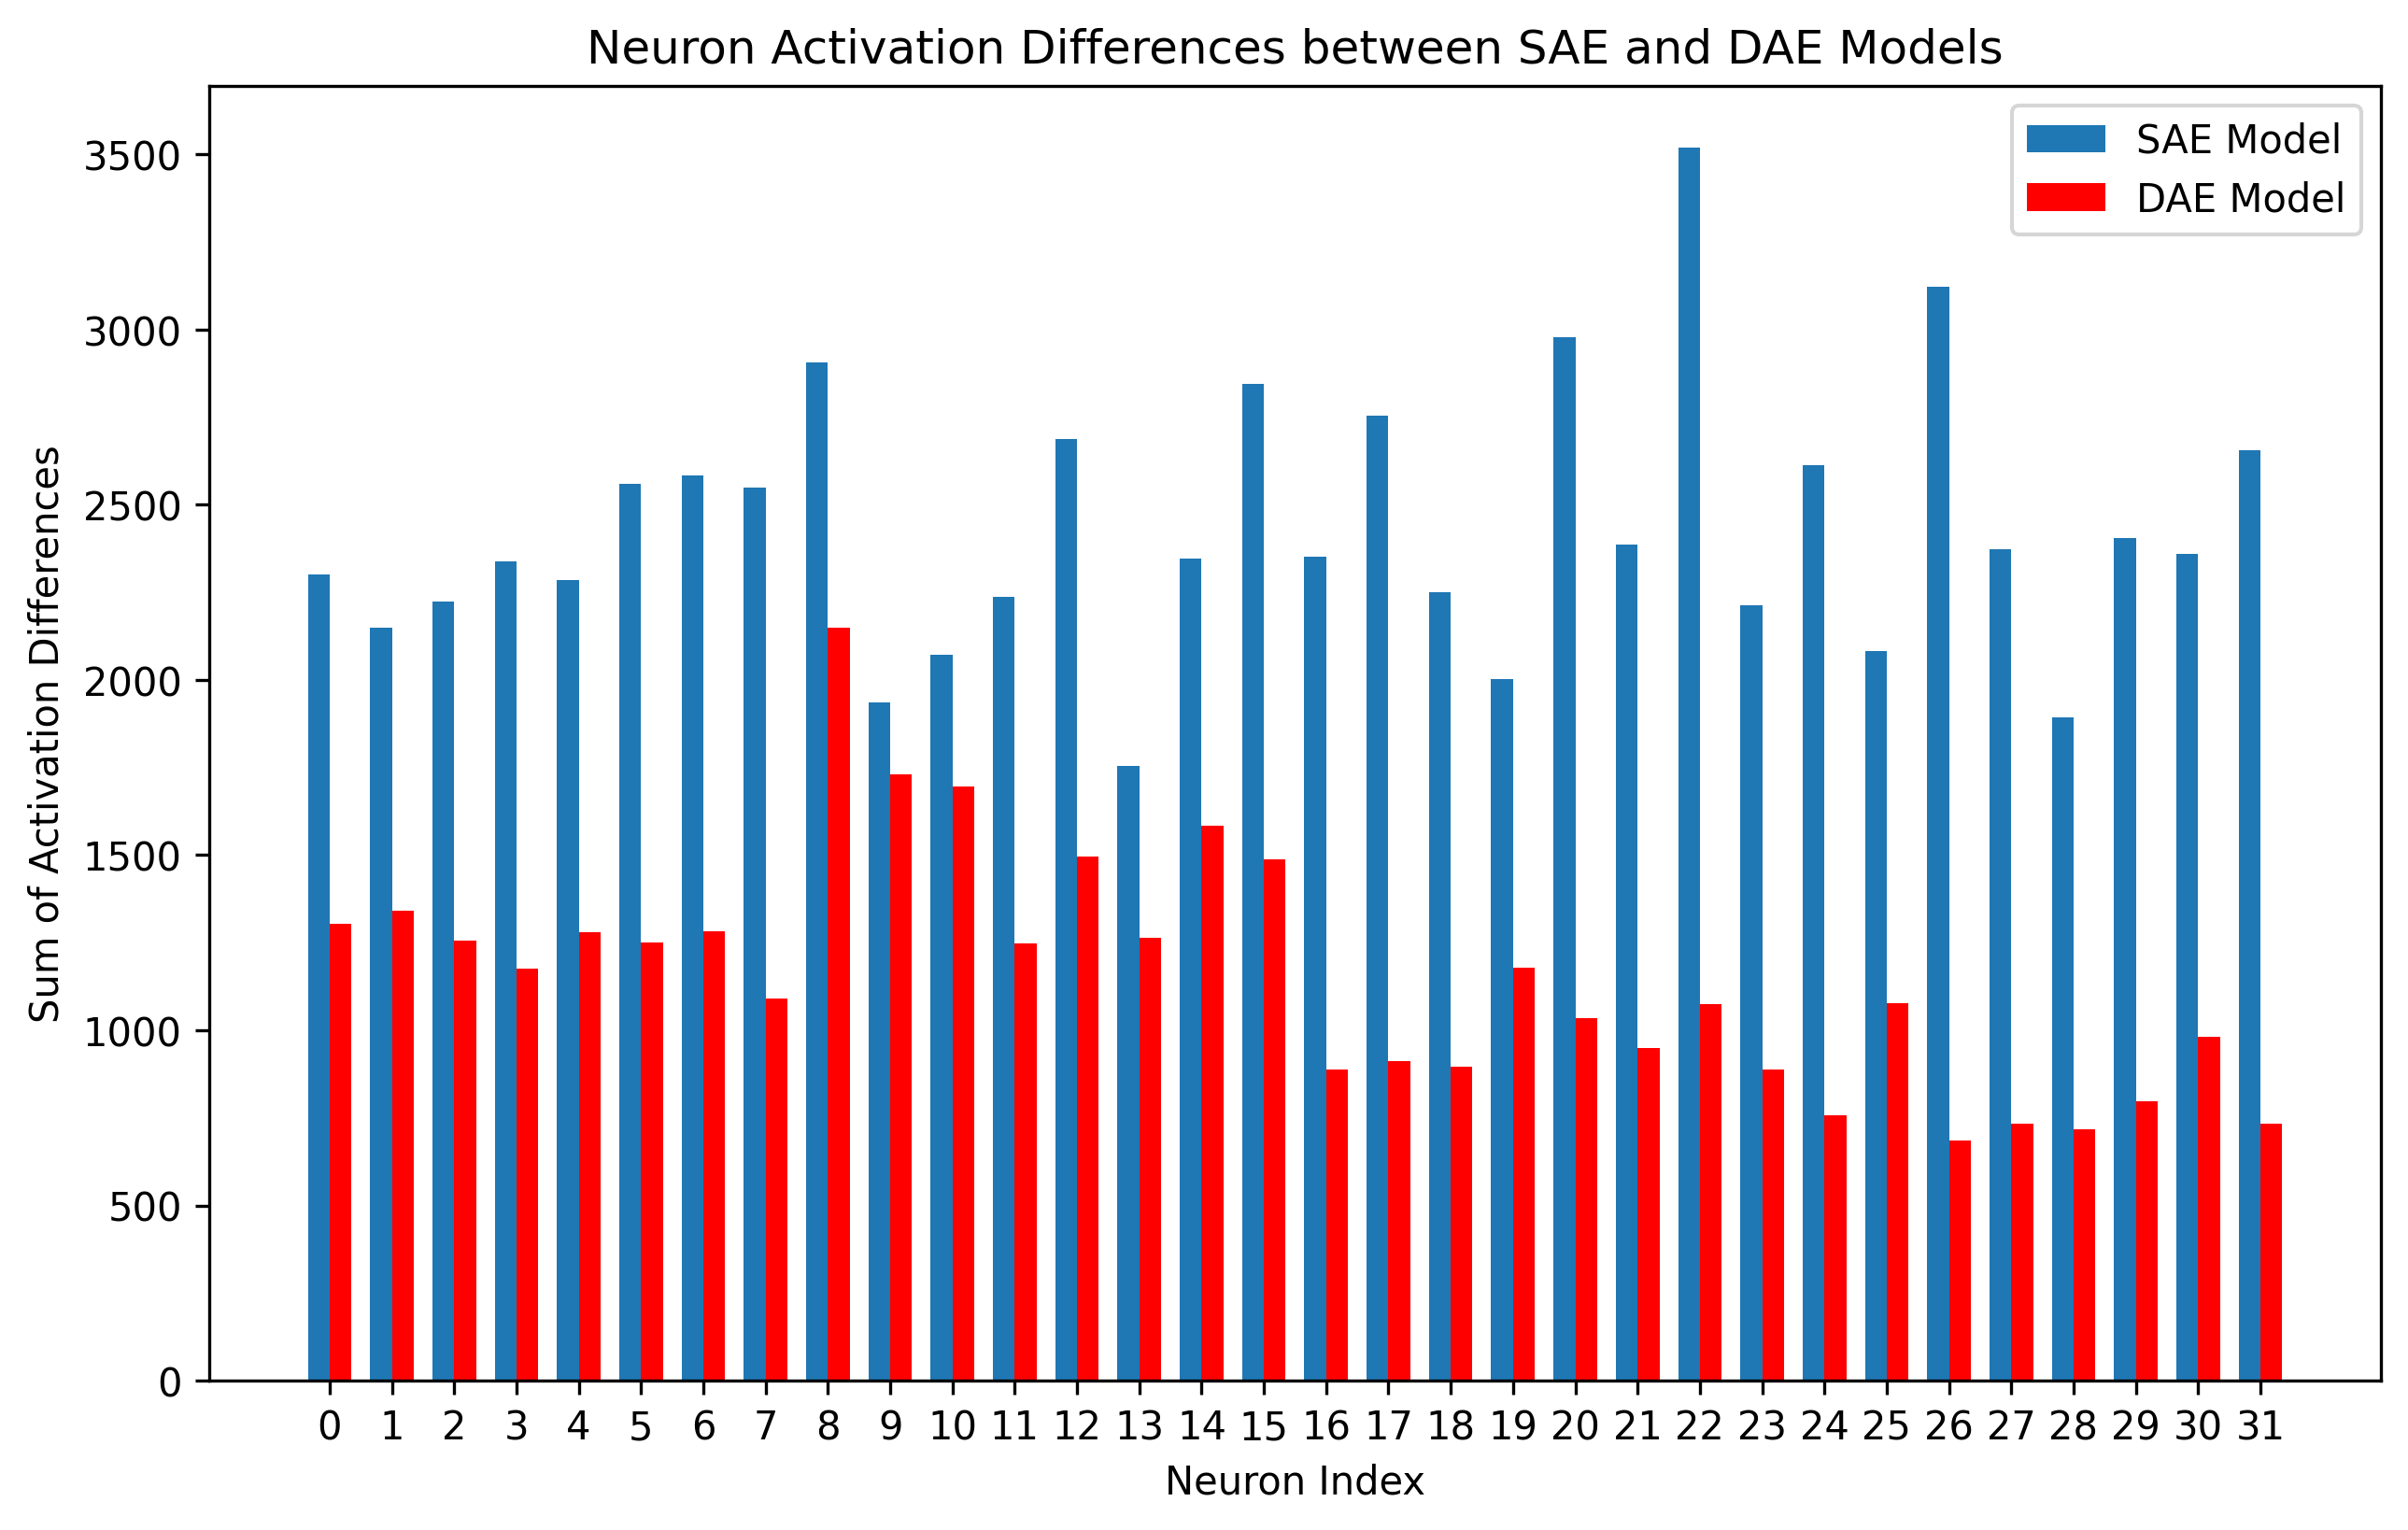

In [116]:
neurons = np.arange(num_neurons)

plt.figure(figsize=(10, 6), dpi=300)
bar_width = 0.35

plt.bar(neurons, sae_neuron_differences, bar_width, label='SAE Model')
plt.bar(neurons + bar_width, dae_neuron_differences, bar_width, label='DAE Model', color='red')

plt.xlabel('Neuron Index')
plt.ylabel('Sum of Activation Differences')
plt.title('Neuron Activation Differences between SAE and DAE Models')
plt.xticks(neurons + bar_width / 2, neurons)
plt.legend()
plt.show()